# Computational Exercise 3: Classifying Medical Abstract Sections with Simple NLP Models

*Applied Data Science; June 21, 2019*

**Please note that this exercise is intended to be completed in groups, and may be difficult to complete individually.**

**Due:** *Thursday, July 11 at 11:59pm (extra week for July 4th holiday)*

---
In this exercise, we'll classify sentences belonging to different sections of medical abstracts (e.g. background, methods, etc) using two different approaches:

1. A bag of words classifier
2. A very simple model word embedding-based model

Goals of the exercise are as follows:

- See how raw text data is pre-processed to prepare it for modeling
- Explore count-based text features
- Explore word embeddings
- Determine which approach is more effective for this classification problem
- Understand the limitations of each approach

As usual, we'll begin by importing required libraries:

- numpy for efficient math operations
- pandas for data and dataframe manipulations
- matplotlib for visualization/plotting
- nltk for text pre-processing
- requests to load data from url
- sklearn for training logistic regression and MLP models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /Users/mme/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mme/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We'll be working with the "PubMed 200k RCT dataset" dataset developed by Franck Dernoncourt. This dataset contains sentences found in Pubmed abstracts labeled as:

- OBJECTIVE
- BACKGROUND
- METHODS
- RESULTS
- CONCLUSIONS

Our goal is to develop a classifier that assigns sentences to the correct label. The training, validation, and test data are found at the following addresses:

In [2]:
train_url = 'https://github.com/Franck-Dernoncourt/pubmed-rct/raw/master/PubMed_20k_RCT/train.txt?raw=true'
val_url = 'https://github.com/Franck-Dernoncourt/pubmed-rct/raw/master/PubMed_20k_RCT/dev.txt?raw=true'
test_url = 'https://github.com/Franck-Dernoncourt/pubmed-rct/raw/master/PubMed_20k_RCT/test.txt?raw=true'

Let's define a function to read these data. You're not responsible for understanding this function. However, it is important that the training sentences and labels are loaded as `s_train` and `l_train`, respectively. Similarly, the validation sentences and labels are loaded as `s_val` and `l_val`, and the test sentences and labels are loaded as `s_test` and `l_test`.

In [3]:
def read_pubmed_rct(url):

    labels = []
    sentences = []
    
    with requests.get(url) as r:
        for line in r.iter_lines():
            fields = line.decode('utf-8').strip().split('\t')
            if len(fields) == 2:
                labels.append(fields[0])
                sentences.append(fields[1])
                
    return sentences, labels

s_train, l_train = read_pubmed_rct(train_url)
s_val, l_val = read_pubmed_rct(val_url)
s_test, l_test = read_pubmed_rct(test_url)

print('There are %i sentences in the training set' % len(s_train))
print('There are %i sentences in the validation set' % len(s_val))
print('There are %i sentences in the test set' % len(s_test))

There are 180040 sentences in the training set
There are 30212 sentences in the validation set
There are 30135 sentences in the test set


Now let's take a look at the labels in the training set:

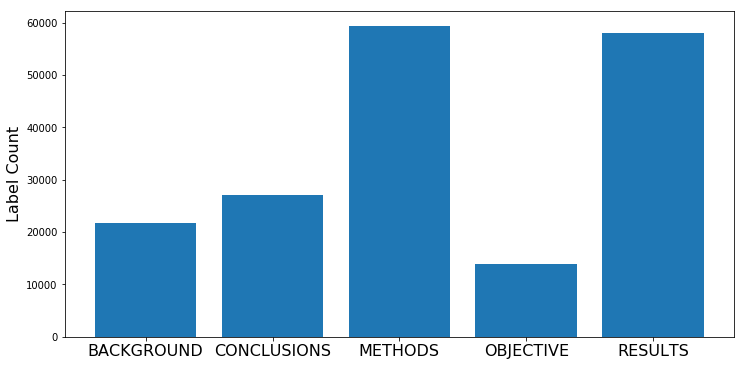

In [4]:
labels, counts = np.unique(l_train, return_counts=True)
plt.figure(figsize=(12, 6))
plt.bar(np.arange(5), counts)
plt.xticks(np.arange(5), labels, fontsize=16)
plt.ylabel('Label Count', fontsize=16)
plt.show()

As we move toward a classification model, we'll need to convert all of our labels to numbers that we can give to our classifier. Let's make sure to number them in the order we'd expect:

1. BACKGROUND
2. OBJECTIVE
3. METHODS
4. RESULTS
5. CONCLUSIONS

We'll do this using the dictionary `label_dict`.

In [5]:
label_dict = {'BACKGROUND': 0, 'OBJECTIVE': 1, 'METHODS': 2, 'RESULTS': 3, 'CONCLUSIONS': 4}

def labels_to_indices(labels):
    return np.array([label_dict[l] for l in labels])

y_train = labels_to_indices(l_train)
y_val = labels_to_indices(l_val)
y_test = labels_to_indices(l_test)

## Pre-Processing

Now let's start preparing our sentences for modeling. We'll use a very simple preprocessing pipline that:

1. tokenizes the sentence, which primarily involves splitting on whitespace. Here we're using NLTK's `word_tokenize()` function.
1. removes stop words (e.g. 'a', 'the')
2. removes tokens with non-alphabetical characters (via `word.isalpha()`)
3. converts words to lowercase (via `word.lower()`)

We can run the whole pipeline on the sentence `test_sentence` by calling `tokenize(test_sentence)`. Take a moment to explore different test sentences and check the result!

In [6]:
def tokenize(sentence):
    return [w.lower() for w in word_tokenize(sentence) if ((not w in stop_words) and w.isalpha())]

test_sentence = 'Here\'s a sentence we\'d like to tokenize.'

print('Sentence:')
print(test_sentence)
print('\nTokenized Sentence:')
print(tokenize(test_sentence))

Sentence:
Here's a sentence we'd like to tokenize.

Tokenized Sentence:
['here', 'sentence', 'like', 'tokenize']


If we're satisfied our preprocessing is working as intended, we can apply it to all of the sentences in our training, validation, and test sets. This might take a few moments.

In [7]:
tokens_train = [tokenize(s) for s in s_train]
tokens_val = [tokenize(s) for s in s_val]
tokens_test = [tokenize(s) for s in s_test]

Now, let's define our vocabulary (as `vocab`) based on the words we encounter in our training set. Currently, we're only including words in our vocabulary if we see them at least 100 times (specified via `min_word_count = 100`). Let's leave it this way for now, but you may want to revisit this choice later in the exercise.

In [8]:
min_word_count = 100

words, counts = np.unique([word for tokens in tokens_train for word in tokens], return_counts=True)
vocab = words[counts > min_word_count]
vocab_dict = {word:idx for idx, word in enumerate(vocab)}

print('Obtained %i vocabulary words. Here are the first 50:\n' % len(vocab))
print(vocab[:50])
print('\nAnd here are the last 50:\n')
print(vocab[-50:])

Obtained 3000 vocabulary words. Here are the first 50:

['a' 'aa' 'abdominal' 'ability' 'ablation' 'able' 'abnormal'
 'abnormalities' 'absence' 'absolute' 'absorption' 'abstinence' 'abuse'
 'academic' 'acceptability' 'acceptable' 'acceptance' 'accepted' 'access'
 'accompanied' 'according' 'account' 'accuracy' 'accurate' 'acetaminophen'
 'acetate' 'achieve' 'achieved' 'achievement' 'achieving' 'acid' 'acids'
 'acl' 'acquired' 'acquisition' 'across' 'acs' 'act' 'action' 'activation'
 'active' 'activities' 'activity' 'actual' 'acuity' 'acupoint' 'acupoints'
 'acupuncture' 'acute' 'ad']

And here are the last 50:

['website' 'week' 'weekly' 'weeks' 'weight' 'well' 'western' 'when'
 'whereas' 'whether' 'while' 'white' 'who' 'whole' 'whose' 'wide' 'widely'
 'width' 'wilcoxon' 'with' 'withdrawal' 'within' 'without' 'wk' 'women'
 'work' 'workers' 'working' 'world' 'worldwide' 'worse' 'worsening'
 'would' 'wound' 'wrist' 'written' 'x' 'year' 'years' 'yet' 'yield'
 'yielded' 'yoga' 'young' 'youn

Having defined our vocabulary, we can now count vocabulary words in each sentence of our data. Once this is done, we'll be just about ready to build our first model. The `word_counts()` function below will take our training dataset and vocabulary and return an $N \times V$ matrix of counts, where $N$ is the number of sentences, and $V$ is the size of our vocabulary. When we encounter vocabulary word $j$ in sentence $i$, we increment the $\{i, j\}^{th}$ element of the counts matrix by one.

In [9]:
def word_counts(tokens_list, vocab_dict):   
    vocab_words = vocab_dict.keys()
    counts = np.zeros((len(tokens_list), len(vocab_words)))
    for idx, tokens in enumerate(tokens_list):
        for token in tokens:
            if token in vocab_words:
                counts[idx, vocab_dict[token]] += 1
    return counts

counts_train = word_counts(tokens_train, vocab_dict)
counts_val = word_counts(tokens_val, vocab_dict)
counts_test = word_counts(tokens_test, vocab_dict)

As a last step before modeling, we'll apply tf-idf. Note that this is implemented just as described in class, except we are 'smoothing' by adding 1s in both the tf and idf steps. This 'smoothing' step is done partly to ensure we're never dividing by zero.

It is also important to note, as discussed in class, that we use only the training data when calculating our document frequency values. This is because we want to make sure we're normalizing all three partitions by the same document frequency, but we cannot use information outside of the training partition when we normalize it.

Our data is now ready for modeling: we have `x_train`, `x_val`, and `x_test` along with the corresponding $y$ values.

In [10]:
def term_freq(counts):
    row_totals = np.sum(counts, axis=1) + 1
    assert np.amin(row_totals) > 0
    return counts / row_totals[:, np.newaxis]

def document_freq(counts):
    col_totals = np.sum((counts > 0).astype('int'), axis=0) + 1
    assert np.amin(col_totals) > 0
    return col_totals[np.newaxis, :] / (len(counts) + 1)

df = document_freq(counts_train)

x_train = term_freq(counts_train) / df
x_val = term_freq(counts_val) / df
x_test = term_freq(counts_test) / df

## Bag of Words Model

We're finally ready to train our model! We'll use the simplest model we can: multi-class logistic regression. Let's see how well it does:

In [11]:
from sklearn.linear_model import LogisticRegression

lrc = LogisticRegression()
lrc.fit(x_train, y_train)
predictions = lrc.predict(x_val)
accuracy = sum(predictions == y_val) / len(predictions)

print('The accuracy is %.1f%%' % (100 * accuracy))

The accuracy is 77.2%


Great! It's working pretty well. Let's take a closer look by plotting the confusion matrix using a function we'll define, `plot_confusion_matrix()`. No need to worry about the details of this function.

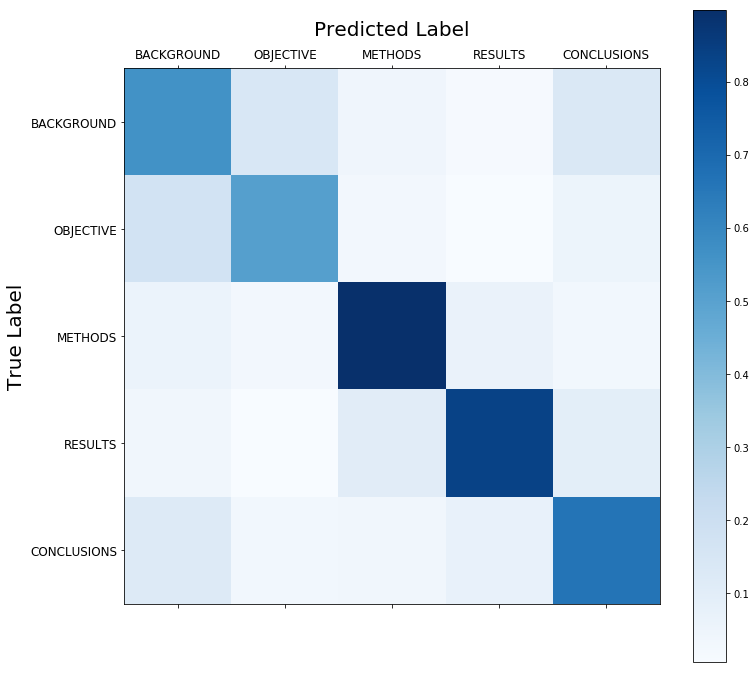

In [12]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(predicted_labels, true_labels, normalize=True):
    cm = confusion_matrix(true_labels, predicted_labels)
    if normalize == True:
        cm = cm / np.sum(cm, axis=1)
    fig, ax = plt.subplots(figsize=(12, 12))
    im = ax.matshow(cm, cmap='Blues')
    fig.colorbar(im, ax=ax)
    ax.set_title('Predicted Label', fontsize=20)
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(label_dict.keys(), fontsize=12)
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels(label_dict.keys(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=20)
    plt.show()
    
plot_confusion_matrix(predictions, y_val)

It looks like the model does best with the methods and the results. Why might this be the case? Looks like it sometimes confuses CONCLUSIONS with BACKGROUND, as well as OBJECTIVE with BACKGROUND. Note that these results are row-normalized, meaning we are looking at the proportion of each true label that are correctly versus incorrectly classified.

Continuing with our exploration, let's take a look at the logistic regression coefficients, which we'll access as `lr_params`. Note that the $n^{th}$ row of `lr_params` contains the parameter values corresponding to class $i$ for each of our vocabulary words. Knowing this, we can see which vocabulary words have largest coefficients for each class. Here we're looking at the top 10, but you can look at more or fewer words by changing the value of `k`.

In [13]:
lr_params = lrc.coef_
inverse_vocab_dict = {i: w for w, i in vocab_dict.items()}

def topk_words(arr, k):
    indices = np.argsort(arr)[::-1][:k]
    return [inverse_vocab_dict[idx] for idx in indices]

k = 10

topk_items_dict = {lbl: topk_words(lr_params[i, :], k) for lbl, i in label_dict.items()}

print('The top %i items for each label, as ranked by their logistic regression coefficients, are:' % k)
pd.DataFrame(topk_items_dict)[list(label_dict.keys())]

The top 10 items for each label, as ranked by their logistic regression coefficients, are:


,BACKGROUND,OBJECTIVE,METHODS,RESULTS,CONCLUSIONS
0,aim,to,randomized,p,patients
1,studies,patients,randomly,patients,the
2,aimed,study,primary,group,study
3,whether,the,the,significantly,trial
4,however,treatment,groups,ci,treatment
5,cancer,compared,assessed,significant,clinical
6,shown,this,study,the,this
7,trials,we,using,respectively,effect
8,disease,clinical,weeks,groups,effective
9,objective,trial,used,mean,may


### Exercise 1: Logistic Regression Coefficients

In one or two brief paragraphs, please comment on the table above, touching on at least one of the following points:

- the significance of these words to the model's predictions
- words present on these lists that match -- or don't match -- your expectations
- words absent from these lists that you expected to see

--- 

**YOUR RESPONSE HERE**

### Exercise 2: Improving the Model

In the code block below -- and elsewhere if needed -- make at least one modification to (a) the model, or (b) our pre-processing that you hypothesize will improve the results. For example, you might change:

- the logistic regression model to an MLP of your choice (you can consult computational exercise 1 to see how)
- the logistic regression model to any other classifier of your choice
- hyperparameters of the logistic regression model, such as the regularization type or penalty
- the vocabulary size (by changing `min_word_count`)
- exntend the model to include 2-grams
- pre-processing, for example by adding stemming from NLTK

Then, in a brief paragraph below, describe whether your modification was effective and why this might be.

---

**YOUR RESPONSE HERE**

In [ ]:
### YOUR CODE BELOW ###





### YOUR CODE ABOVE ###

## Word Embeddings

Now we'll tackle the same problems using word embeddings. Specifically, we'll work toward the very simple word embedding-based model we discussed in class. Let's start by loading 300-dimensional embeddings from the Stanford NLP group (i.e. GloVe). No need to worry about how we're loading the file, but it's important to note that we can access the vector for `'word'` as `glove_dict['word']`.

In [44]:
import requests
import shutil

response = requests.get(
    'https://github.com/mengelhard/mmci_applied_ds/raw/master/data/glove/ce3_glove.npy',
    stream=True)

with open('glove.npy', 'wb') as fin:
    shutil.copyfileobj(response.raw, fin)

glove_dict = np.load('glove.npy').item()

How rich is the vocabulary we get from our word vectors? Let's look for some medical jargon -- please try a few of your own terms! Note that this dictionary contains words in **both** our dataset and in GloVe, so you won't find legal terminology, for instance.

In [48]:
print('Is the word \'myocardium\' in our dictionary?')
print('myocardium' in glove_dict.keys())
print('Is the word \'peristalsis\' in our dictionary?')
print('peristalsis' in glove_dict.keys())
print('Is the word \'aneurysm\' in our dictionary?')
print('aneurysm' in glove_dict.keys())

Is the word 'myocardium' in our dictionary?
True
Is the word 'peristalsis' in our dictionary?
True
Is the word 'aneurysm' in our dictionary?
True


Using our word vectors, we can evaluate the similarity between pairs of words in our dictionary by taking a dot product, which gives us the cosine of the angle between the two word vectors (since these vectors have been unit-normalized). 

- When the angle $\theta$ is close to zero, $\cos(\theta)$ will be close to 1.
- As $\theta$ gets larger, $\cos(\theta)$ gets smaller (and, in some cases, negative).

The function `word_similarity()` calculates the similarity between pairs of words that you specify. Let's look at a few examples:

In [70]:
def word_similarity(word1, word2):
    if not word1 in glove_dict.keys():
        print('Word 1 not found')
    elif not word2 in glove_dict.keys():
        print('Word 2 not found')
    else:
        return np.sum(glove_dict[word1] * glove_dict[word2])

print(word_similarity('humans', 'animals'))
print(word_similarity('plants', 'animals'))
print(word_similarity('plants', 'fungi'))
print(word_similarity('bacteria', 'fungi'))

0.6924787002223816
0.4238939074681611
0.360898329886003
0.6108787478970699


### Exercise 3: Explore Word Embeddings

This is an open-ended exercise; the goal is for you to explore word vectors on your own. Please include the following in your exploration:

1. find at least one additional medical term that is present in the dictionary, and at least one term (from any domain) that is absent
2. calculate the cosine similarity for at least one pair of words that are similar, for which you'd expect the similarity to be close to 1
3. calculate the cosine similarity for at least one pair of words that are similar, for which you'd expect the cosine similarity to be smaller

In [ ]:
### YOUR CODE BELOW ###





### YOUR CODE ABOVE ###

## A Very Simple Word Embedding-Based Model

We'll now apply the simple model discussed in class and see how it compares to our previous approach. We will apply the `swem()` function to each sentence in our dataset. This function will map each word in the sentence to its GloVe vector (if one is found), stack all the sentences together, and take the `max()` and `average()` over all words. These are then concatenated, resulting in a 600-dimensional feature vector for each sentence. This may take a minute or two.

In [71]:
glove_vocab = glove_dict.keys()

def swem(t_list):
    arr = []
    for t in t_list:
        if t in glove_vocab:
            arr.append(glove_dict[t])
    if len(arr) == 0:
        return np.zeros(600)
    elif len(arr) == 1:
        return np.concatenate(arr + arr)
    else:
        arr = np.stack(arr)
        swem_max = np.amax(arr, axis=0)
        swem_avg = np.mean(arr, axis=0)
        return np.concatenate([swem_max, swem_avg])

x_train_swem = np.stack([swem(tokens) for tokens in tokens_train])
x_val_swem = np.stack([swem(tokens) for tokens in tokens_val])
x_test_swem = np.stack([swem(tokens) for tokens in tokens_test])

Let's quickly verify that the result came out as expected:

In [72]:
np.shape(x_train_swem), np.shape(x_val_swem), np.shape(x_test_swem)

((180040, 600), (30212, 600), (30135, 600))

Now we can apply logistic regression to our new, SWEM-based feature vector!

The accuracy is 70.8%


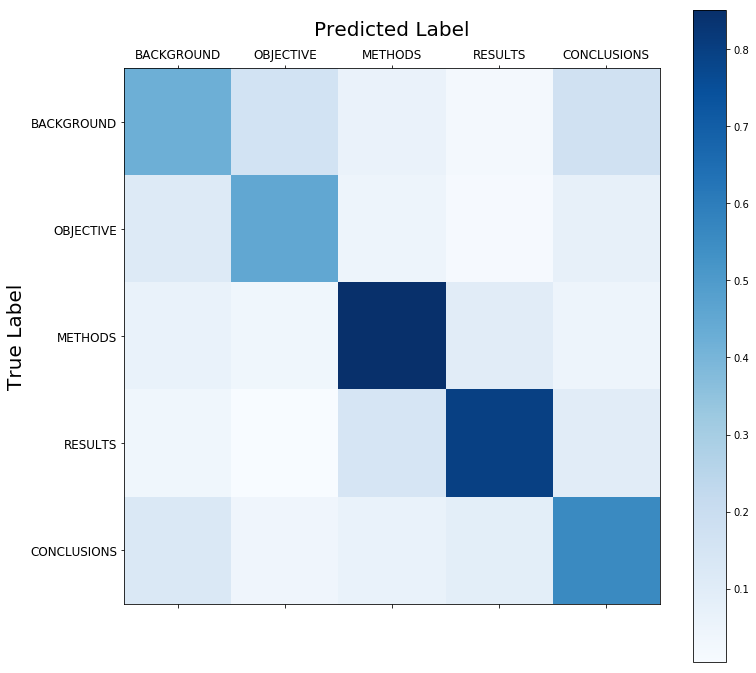

In [73]:
from sklearn.linear_model import LogisticRegression

lrc = LogisticRegression()
lrc.fit(x_train_swem, y_train)
predictions = lrc.predict(x_val_swem)
accuracy = sum(predictions == y_val) / len(predictions)

print('The accuracy is %.1f%%' % (100 * accuracy))
plot_confusion_matrix(predictions, y_val)

### Exercise 4: Interpreting SWEM Results

It looks like the SWEM model performed well, but not quite as well as our earlier, bag of words approach. In a brief paragraphs below, please describe at least **two** limitations of SWEM, preferably including one not shared by the bag of words model, that might help explain this difference.

---

**YOUR RESPONSE HERE**

Can we improve our results using a multilayer perceptron? Let's find out...

The accuracy is 76.9%


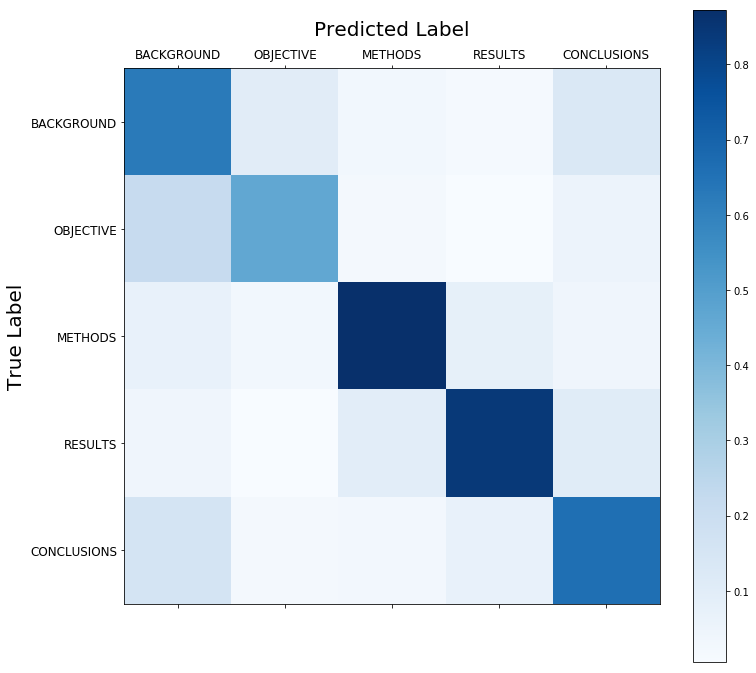

In [74]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(300,), early_stopping=True)
mlp.fit(x_train_swem, y_train)
predictions = mlp.predict(x_val_swem)
accuracy = sum(predictions == y_val) / len(predictions)

print('The accuracy is %.1f%%' % (100 * accuracy))
plot_confusion_matrix(predictions, y_val)